In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, mean_squared_error
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
import time
import torch.utils.data as torch_data

## 1. Reconstruction of Cifar10 with MLP-based autoencoder

### 1.0 Cifar-10 data preparation:

In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step


In [0]:
x_test=x_test[:1000]
y_test=y_test[:1000]
#x_train=x_train[:5000]
#y_train=y_train[:5000]

In [0]:

img_rows, img_cols = 32, 32
x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols*3)
x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols*3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("[cifar] x_train.shape={}, y_train.shape={}".format(x_train.shape, y_train.shape))
print("[cifar] x_test.shape={}, y_test.shape={}".format(x_test.shape, y_test.shape))

transform = transforms.Compose([transforms.ToTensor()])

train_loader = torch.utils.data.DataLoader(x_train, batch_size=500,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(x_test, batch_size=500,
                                         shuffle=False, num_workers=2)

[cifar] x_train.shape=(50000, 3072), y_train.shape=(50000, 1)
[cifar] x_test.shape=(1000, 3072), y_test.shape=(1000, 1)


In [0]:
x_train.shape

(50000, 3072)

### 1.1 MLP-1

#### 1.1.1 MLP-1 architecture:

In [0]:
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x=x.reshape(x.shape[0],-1)
        return self.decoder(self.encoder(x))


In [0]:
encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(3072,4096, bias=True),
                        torch.nn.BatchNorm1d(4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),

                        torch.nn.Linear(4096,1024, bias=True),
                        torch.nn.BatchNorm1d(1024),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                  
                        torch.nn.Linear(1024, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 1024, bias=True),
                        torch.nn.BatchNorm1d(1024),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),

                        torch.nn.Linear(1024, 4096, bias=True),
                        torch.nn.BatchNorm1d(4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                        
                        torch.nn.Linear(4096, 3072, bias=True),
                       # torch.nn.BatchNorm1d(3072),
                        torch.nn.ReLU(),
                        ) 

In [0]:
device = 'cuda:0'

net = AE(encoder(500), decoder(500))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [0]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None):
    print("construction started", time.strftime("%H:%M:%S", time.localtime()))
    start=time.time()
    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        for X  in train_loader:
            # Perform one step of minibatch stochastic gradient descent 
          
          X=X.to(device)
        
          out=net(X)
          loss=criterion(out,X)

          optimizer.zero_grad()

          loss.backward()
          optimizer.step()
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
    
        net.eval()
        for X in val_loader:
            # Compute the validation loss
             
            X=X.to(device)
            out=net(X)
            val_loss=criterion(out,X)
         
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), val_loss.item()))
    end=time.time()
    print("construction completed", time.strftime("%H:%M:%S", time.localtime()))
    print(f"Time cost for training (in seconds): {end-start}")


#### 1.1.2 Training MLP-1:

In [0]:
epochs = 500
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

construction started 10:37:49
Epoch 25/500 || Loss:  Train 1325.5891 | Validation 1303.3669
Epoch 50/500 || Loss:  Train 1055.1545 | Validation 922.5033
Epoch 75/500 || Loss:  Train 840.5447 | Validation 795.9658
Epoch 100/500 || Loss:  Train 835.7357 | Validation 725.0182
Epoch 125/500 || Loss:  Train 797.8741 | Validation 691.9574
Epoch 150/500 || Loss:  Train 757.0522 | Validation 651.4977
Epoch 175/500 || Loss:  Train 732.3753 | Validation 625.5750
Epoch 200/500 || Loss:  Train 725.9635 | Validation 600.8474
Epoch 225/500 || Loss:  Train 707.8401 | Validation 596.5363
Epoch 250/500 || Loss:  Train 652.1193 | Validation 578.6125
Epoch 275/500 || Loss:  Train 684.9975 | Validation 565.6489
Epoch 300/500 || Loss:  Train 653.5179 | Validation 557.6228
Epoch 325/500 || Loss:  Train 637.2025 | Validation 556.5551
Epoch 350/500 || Loss:  Train 620.8018 | Validation 550.8251
Epoch 375/500 || Loss:  Train 628.0652 | Validation 538.2993
Epoch 400/500 || Loss:  Train 622.4285 | Validation 542

#### 1.1.3 Resulting pictures:

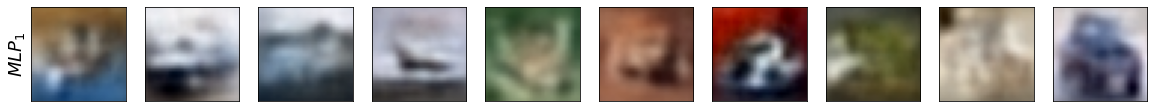

In [0]:
from google.colab import files
net.eval()
batch_count=0
reconstruction_time=[]
running_loss_val = 0.0
i = 0
for X in test_loader:
    X=X.to(device)
    encoded_imgs = net.encoder(X)
    start=time.time()
    decoded_imgs = net.decoder(encoded_imgs)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec1 = decoded_imgs
    else:
      rec1 = torch.cat((rec1, decoded_imgs), dim=0)
    batch_count += 1
    loss_val = criterion(decoded_imgs, X)
    running_loss_val += loss_val.item()

rec1 = rec1.cpu().detach().numpy()
fig, ax = plt.subplots(ncols=10, nrows=1, figsize=(20, 2.5))
for i in range(10):
  ax[i].imshow(rec1[i].reshape(32,32,3).astype('int'))
  ax[i].get_xaxis().set_ticks([])
  ax[i].get_yaxis().set_ticks([])
ax[0].set_ylabel(f"$MLP_1$",fontsize=18)
fig.savefig('mlp1.png')

In [0]:
files.download('mlp1.png') 

#### 1.1.4 MSE and Decoding time datas

In [0]:
mean=np.mean(np.array(reconstruction_time))
print(f'MSE of the MLP-1 AE on the 1000 test MNIST images: {running_loss_val/batch_count}')
print(f"Decoding time {mean} is measured in sample per seconds")

MSE of the MLP-1 AE on the 1000 test MNIST images: 518.4159240722656
Decoding time 0.0004286766052246094 is measured in sample per seconds


### 1.2 MLP-2

#### 1.2.1 MLP-2 architecture:

In [0]:
encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(3072,4096, bias=True),
                        torch.nn.BatchNorm1d(4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),

                        torch.nn.Linear(4096,2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                  
                        torch.nn.Linear(2048, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),

                        torch.nn.Linear(2048, 4096, bias=True),
                        torch.nn.BatchNorm1d(4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                        
                        torch.nn.Linear(4096, 3072, bias=True),
                       # torch.nn.BatchNorm1d(3072),
                        torch.nn.ReLU(),
                        ) 

In [0]:
device = 'cuda:0'

net = AE(encoder(1000), decoder(1000))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)


#### 1.2.2 Training MLP-2:

In [0]:
epochs = 500
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

construction started 13:57:36
Epoch 25/500 || Loss:  Train 1325.9329 | Validation 1287.0867
Epoch 50/500 || Loss:  Train 975.9816 | Validation 892.4507
Epoch 75/500 || Loss:  Train 832.4733 | Validation 764.7781
Epoch 100/500 || Loss:  Train 773.1375 | Validation 683.2209
Epoch 125/500 || Loss:  Train 710.9124 | Validation 630.0600
Epoch 150/500 || Loss:  Train 678.6677 | Validation 597.0660
Epoch 175/500 || Loss:  Train 650.5349 | Validation 576.1177
Epoch 200/500 || Loss:  Train 633.8613 | Validation 551.6616
Epoch 225/500 || Loss:  Train 595.9768 | Validation 542.7571
Epoch 250/500 || Loss:  Train 596.3596 | Validation 525.8347
Epoch 275/500 || Loss:  Train 579.3506 | Validation 529.2427
Epoch 300/500 || Loss:  Train 541.2328 | Validation 515.5375
Epoch 325/500 || Loss:  Train 552.1044 | Validation 494.6826
Epoch 350/500 || Loss:  Train 546.7946 | Validation 498.0823
Epoch 375/500 || Loss:  Train 544.5027 | Validation 484.7570
Epoch 400/500 || Loss:  Train 539.8803 | Validation 483.

#### 1.2.3 Resulting pictures:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


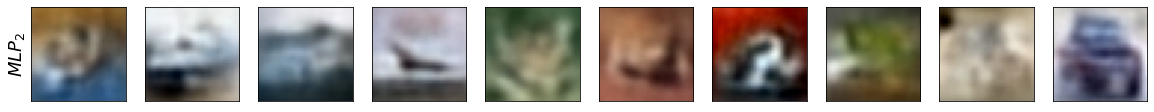

In [0]:
from google.colab import files
net.eval()
batch_count=0
reconstruction_time=[]
running_loss_val = 0.0
i = 0
for X in test_loader:
    X=X.to(device)
    encoded_imgs = net.encoder(X)
    start=time.time()
    decoded_imgs = net.decoder(encoded_imgs)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec2 = decoded_imgs
    else:
      rec2 = torch.cat((rec2, decoded_imgs), dim=0)
    batch_count += 1
    loss_val = criterion(decoded_imgs, X)
    running_loss_val += loss_val.item()

rec2 = rec2.cpu().detach().numpy()
fig, ax = plt.subplots(ncols=10, nrows=1, figsize=(20, 2.5))
for i in range(10):
  ax[i].imshow(rec2[i].reshape(32,32,3).astype('int'))
  ax[i].get_xaxis().set_ticks([])
  ax[i].get_yaxis().set_ticks([])
ax[0].set_ylabel(f"$MLP_2$",fontsize=18)
fig.savefig('mlp2.png')

In [0]:
from google.colab import files

files.download('mlp2.png') 

#### 1.2.4 MSE and Decoding time datas

In [0]:
mean=np.mean(np.array(reconstruction_time))
print(f'MSE of the MLP-2 AE on the 1000 test MNIST images: {running_loss_val/batch_count}')
print(f"Decoding time {mean} is measured in sample per seconds")

MSE of the MLP-2 AE on the 1000 test MNIST images: 468.6983337402344
Decoding time 0.00046443939208984375 is measured in sample per seconds


## 2. MLP-2 Damage Tolerable

### 2.0 Cifar-10 data preparation:

In [0]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_test=x_test[:1000]
#x_train=x_train[:5000]
y_test=y_test[:1000]
#y_train=y_train[:5000]


### 2.1 MLP-2

#### 2.1.1 MLP-2 architecture with changeable dropouts:

In [0]:
encoder = lambda hid, damage: nn.Sequential(
                        torch.nn.Linear(3072,4096, bias=True),
                        torch.nn.BatchNorm1d(4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=damage),

                        torch.nn.Linear(4096,2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=damage),
                  
                        torch.nn.Linear(2048, hid,bias=True),
                        ) 

decoder =  lambda hid, damage: nn.Sequential( 
                        torch.nn.Linear(hid, 2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=damage),

                        torch.nn.Linear(2048, 4096, bias=True),
                        torch.nn.BatchNorm1d(4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=damage),
                        
                        torch.nn.Linear(4096, 3072, bias=True),
                        torch.nn.ReLU(),
                        )

#### 2.1.2 Training MLP-2:

In [0]:
damages=[0, 0.25, 0.5, 0.75]
mse=[]
REC=[]
for dmg in damages:
  device = 'cuda:0'
  net = AE(encoder(1000,dmg), decoder(1000,dmg))  
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
  epochs = 500
  train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

  net.eval()
  batch_count=0
  reconstruction_time=[]
  running_loss_val = 0.0
  i = 0
  for X in test_loader:
      X=X.to(device)
      encoded_imgs = net.encoder(X)
      start=time.time()
      decoded_imgs = net.decoder(encoded_imgs)
      end=time.time()
      reconstruction_time.append(end-start)
      if batch_count == 0:
        rec0 = decoded_imgs
      else:
        rec0 = torch.cat((rec0, decoded_imgs), dim=0)
      batch_count += 1
      loss_val = criterion(decoded_imgs, X)
      running_loss_val += loss_val.item()
  mse.append(running_loss_val/batch_count)
  REC.append(rec0.cpu().detach().numpy())


construction started 11:33:15
Epoch 25/500 || Loss:  Train 1260.5984 | Validation 1237.5303
Epoch 50/500 || Loss:  Train 763.7018 | Validation 764.6639
Epoch 75/500 || Loss:  Train 538.3927 | Validation 555.7087
Epoch 100/500 || Loss:  Train 424.8854 | Validation 458.1812
Epoch 125/500 || Loss:  Train 351.2299 | Validation 392.9438
Epoch 150/500 || Loss:  Train 272.4540 | Validation 346.3434
Epoch 175/500 || Loss:  Train 259.7467 | Validation 322.9785
Epoch 200/500 || Loss:  Train 212.3025 | Validation 290.2824
Epoch 225/500 || Loss:  Train 193.8531 | Validation 277.4062
Epoch 250/500 || Loss:  Train 169.9107 | Validation 261.8527
Epoch 275/500 || Loss:  Train 163.4535 | Validation 256.2344
Epoch 300/500 || Loss:  Train 146.3906 | Validation 244.2619
Epoch 325/500 || Loss:  Train 136.6449 | Validation 233.0586
Epoch 350/500 || Loss:  Train 137.7112 | Validation 229.6175
Epoch 375/500 || Loss:  Train 128.3913 | Validation 228.1722
Epoch 400/500 || Loss:  Train 114.5147 | Validation 217.

#### 2.1.3 Resulting pictures:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


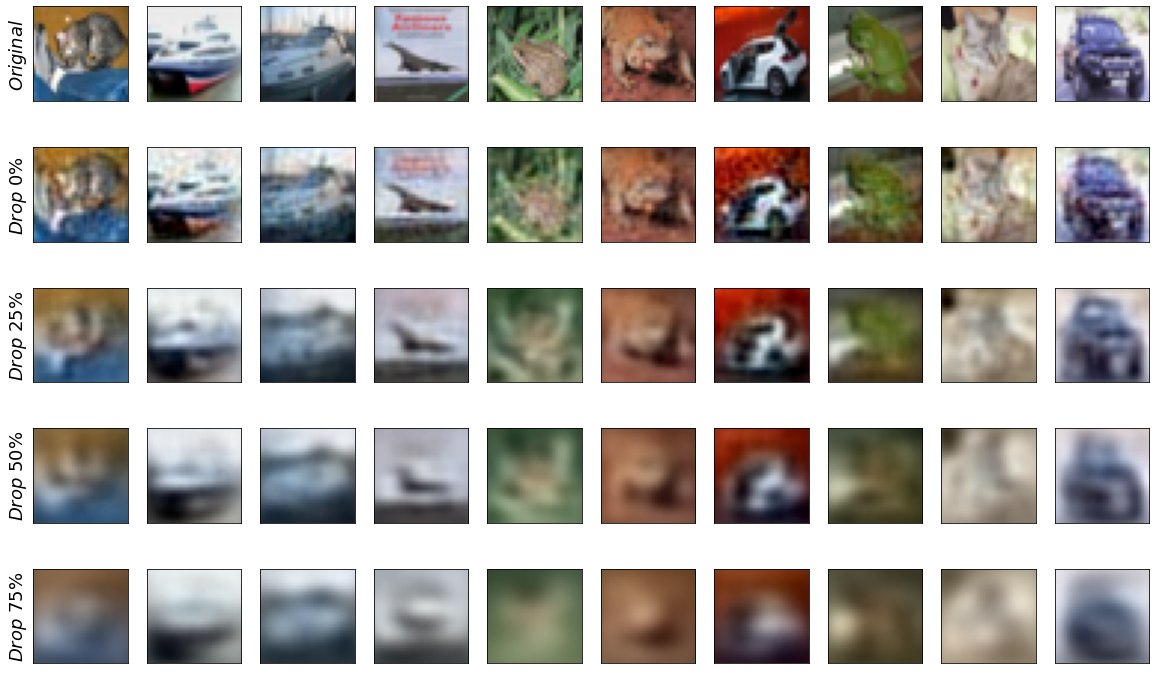

In [0]:
fig, ax = plt.subplots(ncols=10, nrows=5, figsize=(20, 2.5*5))
for i in range(10):
  im=x_test[i]
  ax[0, i].imshow(im.reshape(32,32,3).astype('int'));
  ax[0, i].get_xaxis().set_ticks([])
  ax[0, i].get_yaxis().set_ticks([])
  ax[0, 0].set_ylabel(f"$Original$",fontsize=18)
for i in range(10):
  ax[1, i].imshow(REC[0][i].reshape(32,32,3).astype('int'))
  ax[1, i].get_xaxis().set_ticks([])
  ax[1, i].get_yaxis().set_ticks([])
  ax[1, 0].set_ylabel(f"$Drop$ 0%",fontsize=18)
  ax[2, i].imshow(REC[1][i].reshape(32,32,3).astype('int'))
  ax[2, i].get_xaxis().set_ticks([])
  ax[2, i].get_yaxis().set_ticks([])
  ax[2, 0].set_ylabel(f"$Drop$ 25%",fontsize=18)
  ax[3, i].imshow(REC[2][i].reshape(32,32,3).astype('int'))
  ax[3, i].get_xaxis().set_ticks([])
  ax[3, i].get_yaxis().set_ticks([])
  ax[3, 0].set_ylabel(f"$Drop$ 50%",fontsize=18)
  ax[4, i].imshow(REC[3][i].reshape(32,32,3).astype('int'))
  ax[4, i].get_xaxis().set_ticks([])
  ax[4, i].get_yaxis().set_ticks([])
  ax[4, 0].set_ylabel(f"$Drop$ 75%",fontsize=18)
fig.savefig('mlp0.png') 

In [0]:
from google.colab import files

files.download('mlp0.png') 

#### 2.1.4 MSE datas for each dropout:

In [0]:
print('MSE of the MLP-2 AE on the 1000 test MNIST images with damaged neurons:')
for i in range(0, len(mse)):
  print('Percentage of damagement: %.2f MSE: %.5f' %(damages[i]*100, mse[i]))

MSE of the MLP-2 AE on the 1000 test MNIST images with damaged neurons:
Percentage of damagement: 0.00 MSE: 205.24734
Percentage of damagement: 25.00 MSE: 483.57095
Percentage of damagement: 50.00 MSE: 664.59189
Percentage of damagement: 75.00 MSE: 975.06531


##3. MLP-2 train: cifar/test: mnist

## 3.0 Cifar-10/MNIST data preparation

In [0]:
from keras.datasets import mnist
from keras.datasets import cifar10

(x_train, y_train), _ = cifar10.load_data()
_, (x_test, y_test) = mnist.load_data()



In [0]:
x_test_1=np.zeros((1000, 32,32,3))
for k in range(0, x_test_1.shape[0]):
  for i in range(0,28):
    for j in range(0,28):
      for l in range(0,3):
        x_test_1[k][i+2][j+2][l]=x_test[k][i][j]

In [0]:
x_test=x_test_1

In [0]:
img_rows, img_cols = 32, 32
x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols*3)
x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols*3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("[cifar] x_train.shape={}, y_train.shape={}".format(x_train.shape, y_train.shape))
print("[mnist] x_test.shape={}, y_test.shape={}".format(x_test.shape, y_test.shape))

transform = transforms.Compose([transforms.ToTensor()])

train_loader = torch.utils.data.DataLoader(x_train, batch_size=500,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(x_test, batch_size=500,
                                         shuffle=False, num_workers=2)

[cifar] x_train.shape=(50000, 3072), y_train.shape=(50000, 1)
[mnist] x_test.shape=(1000, 3072), y_test.shape=(10000,)


## 3.1 MLP-2

### 3.1.1 MLP-2 architecture: 

In [0]:
encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(3072,4096, bias=True),
                        torch.nn.BatchNorm1d(4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),

                        torch.nn.Linear(4096,2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                  
                        torch.nn.Linear(2048, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),

                        torch.nn.Linear(2048, 4096, bias=True),
                        torch.nn.BatchNorm1d(4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                        
                        torch.nn.Linear(4096, 3072, bias=True),
                       # torch.nn.BatchNorm1d(3072),
                        torch.nn.ReLU(),
                        ) 

In [0]:
device = 'cuda:0'

net = AE(encoder(1000), decoder(1000))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

### 3.1.2 Training MLP-2:

In [0]:
epochs = 500
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

construction started 19:34:44
Epoch 25/500 || Loss:  Train 1376.0778 | Validation 3083.8267
Epoch 50/500 || Loss:  Train 954.7869 | Validation 2469.2490
Epoch 75/500 || Loss:  Train 843.7523 | Validation 2110.8196
Epoch 100/500 || Loss:  Train 743.5620 | Validation 1783.3903
Epoch 125/500 || Loss:  Train 691.8757 | Validation 1631.0255
Epoch 150/500 || Loss:  Train 693.7354 | Validation 1487.1313
Epoch 175/500 || Loss:  Train 641.3723 | Validation 1371.8848
Epoch 200/500 || Loss:  Train 627.9100 | Validation 1277.0800
Epoch 225/500 || Loss:  Train 613.1365 | Validation 1237.3247
Epoch 250/500 || Loss:  Train 580.9884 | Validation 1183.7979
Epoch 275/500 || Loss:  Train 572.9656 | Validation 1137.7168
Epoch 300/500 || Loss:  Train 556.5283 | Validation 1111.0093
Epoch 325/500 || Loss:  Train 565.1192 | Validation 1072.0323
Epoch 350/500 || Loss:  Train 544.4299 | Validation 1039.9390
Epoch 375/500 || Loss:  Train 541.3953 | Validation 1034.5916
Epoch 400/500 || Loss:  Train 537.2206 | V

### 3.1.3 Resulting pictures:

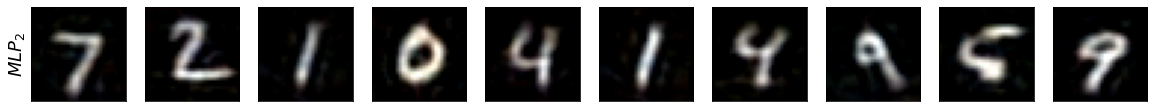

In [0]:
from google.colab import files
net.eval()
batch_count=0
reconstruction_time=[]
running_loss_val = 0.0
i = 0
for X in test_loader:
    X=X.to(device)
    encoded_imgs = net.encoder(X)
    start=time.time()
    decoded_imgs = net.decoder(encoded_imgs)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec3 = decoded_imgs
    else:
      rec3 = torch.cat((rec3, decoded_imgs), dim=0)
    batch_count += 1
    loss_val = criterion(decoded_imgs, X)
    running_loss_val += loss_val.item()

rec3 = rec3.cpu().detach().numpy()
fig, ax = plt.subplots(ncols=10, nrows=1, figsize=(20, 2.5))
for i in range(10):
  ax[i].imshow(rec3[i].reshape(32,32,3).astype('int'))
  ax[i].get_xaxis().set_ticks([])
  ax[i].get_yaxis().set_ticks([])
ax[0].set_ylabel(f"$MLP_2$",fontsize=18)
fig.savefig('mlp3.png')

In [0]:
files.download('mlp3.png')

### 3.1.4 MSE and Decoding time datas

In [0]:
mean=np.mean(np.array(reconstruction_time))
print(f'MSE of the MLP-2 AE on the 1000 test MNIST images: {running_loss_val/batch_count}')
print(f"Decoding time {mean} is measured in sample per seconds")

MSE of the MLP-2 AE on the 1000 test MNIST images: 931.1951293945312
Decoding time 0.0005528926849365234 is measured in sample per seconds


##4. MLP-2 train: cifar/test: omniglot

## 4.0 Cifar-10/Omniglot data preparation

In [0]:
import torchvision

dataset = torchvision.datasets.Omniglot(
    root="./data", download=True, transform=torchvision.transforms.ToTensor()
)
label=[]

for i in range(0,len(dataset)):
  if i==0:
    image, _ = dataset[i]
    label.append(dataset[i][1])
    
  elif dataset[i][1]!=label[-1]:
    image=torch.cat((image, dataset[i][0]), dim=0)
    label.append(dataset[i][1])

label0=[]
for i in range(0, 1000):
  if i==0:
    image=torch.cat((image, dataset[i+1][0]), dim=0)
    label0.append(dataset[i+1][1])
  elif dataset[i+1][1]!=label0[-1]:
    image=torch.cat((image, dataset[i+1][0]), dim=0)
    label0.append(dataset[i+1][1])
  if len(label0)>=1000-len(label):
    break

Files already downloaded and verified


In [0]:
x_test=image.numpy()
label=np.array(label)
label0=np.array(label0)
y_test=np.concatenate((label, label0),axis=None)

In [0]:
import cv2
x_test_res=[]
for i in range(0,len(x_test)):
  x_test_res.append(cv2.resize(x_test[i], (32,32)))
x_test_res=np.array(x_test_res)

In [0]:
x_test_res.shape

(1000, 32, 32)

In [0]:
from keras.datasets import cifar10
(x_train, y_train), _ = cifar10.load_data()

In [0]:
x_test_1=np.ones((1000, 32,32,3))
for k in range(0, x_test_1.shape[0]):
  for i in range(0,32):
    for j in range(0,32):
      for l in range(0,3):
        x_test_1[k][i][j][l]=1-x_test_res[k][i][j]


In [0]:
x_test=(x_test_1*255).astype('int')

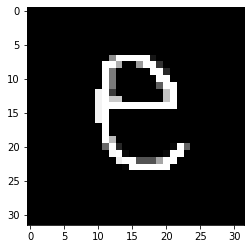

In [0]:
plt.imshow(x_test[0])

In [0]:
img_rows, img_cols = 32, 32
x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols*3)
x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols*3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print("[cifar] x_train.shape={}, y_train.shape={}".format(x_train.shape, y_train.shape))
print("[omniglot] x_test.shape={}, y_test.shape={}".format(x_test.shape, y_test.shape))

transform = transforms.Compose([transforms.ToTensor()])

train_loader = torch.utils.data.DataLoader(x_train, batch_size=500,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(x_test, batch_size=500,
                                         shuffle=False, num_workers=2)

[cifar] x_train.shape=(50000, 3072), y_train.shape=(50000, 1)
[omniglot] x_test.shape=(1000, 3072), y_test.shape=(1000,)


## 4.1 MLP-2

### 4.1.1 MLP-2 architecture:

In [0]:
encoder = lambda hid: nn.Sequential(
                        torch.nn.Linear(3072,4096, bias=True),
                        torch.nn.BatchNorm1d(4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),

                        torch.nn.Linear(4096,2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                  
                        torch.nn.Linear(2048, hid,bias=True),
                        ) 

decoder =  lambda hid: nn.Sequential( 
                        torch.nn.Linear(hid, 2048, bias=True),
                        torch.nn.BatchNorm1d(2048),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),

                        torch.nn.Linear(2048, 4096, bias=True),
                        torch.nn.BatchNorm1d(4096),
                        torch.nn.ReLU(),
                        torch.nn.Dropout(p=0.25),
                        
                        torch.nn.Linear(4096, 3072, bias=True),
                       # torch.nn.BatchNorm1d(3072),
                        torch.nn.ReLU(),
                        ) 

In [0]:
device = 'cuda:0'

net = AE(encoder(1000), decoder(1000))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

### 4.1.2 Training MLP-2

In [0]:
epochs = 500
train(epochs, net, criterion, optimizer, train_loader, test_loader, scheduler=None)

construction started 15:02:21
Epoch 25/500 || Loss:  Train 1372.5303 | Validation 3317.8394
Epoch 50/500 || Loss:  Train 950.6685 | Validation 2898.0720
Epoch 75/500 || Loss:  Train 814.5015 | Validation 2683.1609
Epoch 100/500 || Loss:  Train 766.3228 | Validation 2476.2808
Epoch 125/500 || Loss:  Train 729.6448 | Validation 2350.7622
Epoch 150/500 || Loss:  Train 682.7625 | Validation 2258.3511
Epoch 175/500 || Loss:  Train 638.2441 | Validation 2160.8567
Epoch 200/500 || Loss:  Train 623.1437 | Validation 2111.5122
Epoch 225/500 || Loss:  Train 622.5822 | Validation 2045.1857
Epoch 250/500 || Loss:  Train 604.8943 | Validation 2004.8722
Epoch 275/500 || Loss:  Train 576.2561 | Validation 1967.3036
Epoch 300/500 || Loss:  Train 561.1840 | Validation 1938.7281
Epoch 325/500 || Loss:  Train 569.0846 | Validation 1904.7273
Epoch 350/500 || Loss:  Train 525.2984 | Validation 1884.2943
Epoch 375/500 || Loss:  Train 538.3104 | Validation 1853.1428
Epoch 400/500 || Loss:  Train 547.9067 | V

### 4.1.3 Resulting pictures:

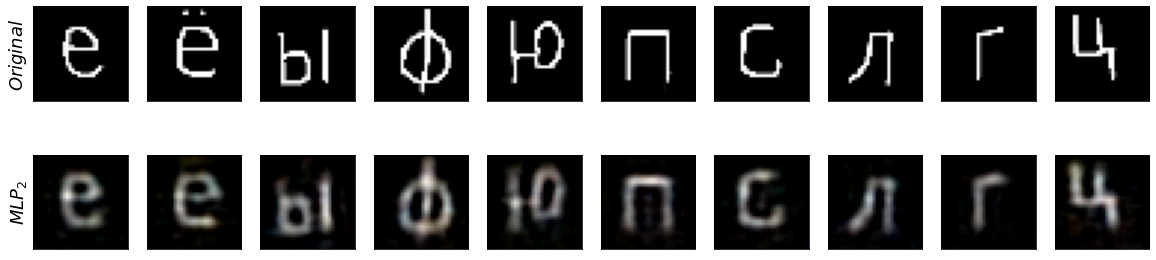

In [0]:
from google.colab import files
net.eval()
batch_count=0
reconstruction_time=[]
running_loss_val = 0.0
i = 0
for X in test_loader:
    X=X.to(device)
    encoded_imgs = net.encoder(X)
    start=time.time()
    decoded_imgs = net.decoder(encoded_imgs)
    end=time.time()
    reconstruction_time.append(end-start)
    if batch_count == 0:
      rec4 = decoded_imgs
    else:
      rec4 = torch.cat((rec4, decoded_imgs), dim=0)
    batch_count += 1
    loss_val = criterion(decoded_imgs, X)
    running_loss_val += loss_val.item()

rec4 = rec4.cpu().detach().numpy()
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))
for i in range(10):
  ax[0,i].imshow(x_test[i].reshape(32,32,3).astype('int'))
  ax[0,i].get_xaxis().set_ticks([])
  ax[0,i].get_yaxis().set_ticks([])
  ax[1,i].imshow(rec4[i].reshape(32,32,3).astype('int'))
  ax[1,i].get_xaxis().set_ticks([])
  ax[1,i].get_yaxis().set_ticks([])
ax[0,0].set_ylabel(f"$Original$",fontsize=18)
ax[1,0].set_ylabel(f"$MLP_2$",fontsize=18)
fig.savefig('mlp4.png')

In [0]:
files.download('mlp4.png')

### 4.1.4 MSE and Decoding time datas

In [0]:
mean=np.mean(np.array(reconstruction_time))
print(f'MSE of the MLP-2 AE on the 1000 test MNIST images: {running_loss_val/batch_count}')
print(f"Decoding time {mean} is measured in sample per seconds")

MSE of the MLP-2 AE on the 1000 test MNIST images: 1855.3131103515625
Decoding time 0.0005227327346801758 is measured in sample per seconds
